# Aux

In [ ]:
import numpy as np
import pennylane as qml 
import torch

def create_circuit(n_qubits,n_layers=None,circ = "simplified_two_design",fim=False, shots=None):

    dev = qml.device("default.qubit.torch", wires=n_qubits, shots=shots)

    def RZRY(params):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        #qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        #qml.AngleEmbedding(params,wires=range(n_qubits))
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        for w in range(n_layers): 
            for q in range(n_qubits):
                index = w * (2*n_qubits) + q * 2
                qml.RZ(params[index],wires=q)
                qml.RY(params[index + 1],wires=q)
        
        qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        
        return qml.probs(wires=range(n_qubits))

    def S2D(init_params,params,measurement_qubits=0,prod_approx=False):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        
        #qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        if not prod_approx:
            return qml.probs(wires=list(range(measurement_qubits)))
        else:
            return [qml.probs(i) for i in range(measurement_qubits)]

    def SU(params):
        qml.SpecialUnitary(params, wires=range(n_qubits))
        
        ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
        for i in range(2,n_qubits):
            ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

        return qml.expval(ZZ)
    
    def simmpleRZRY(params,cnots=True):
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RZ, wires=range(n_qubits), pattern="single", parameters=params[0])
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params[1])
        if cnots:
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

            return qml.expval(qml.PauliZ(n_qubits-1))
        else:
            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

            return qml.expval(ZZ)
        
    def RY(params,y=True,probs=False,prod=False, entanglement=None):
        #qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params)
        #qml.broadcast(qml.CZ, wires=range(n_qubits), pattern="all_to_all")

        if entanglement=="all_to_all":
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")
        
        if y==True:
            #YY = qml.operation.Tensor(qml.PauliY(0), qml.PauliY(1))
            YY = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                #YY = qml.operation.Tensor(YY, qml.PauliY(i))
                YY.append(qml.PauliZ(i))
            
            #return [qml.expval(i) for i in YY]
            return qml.expval(YY)

        elif probs==False:

            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            #ZZ = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))        
                #ZZ.append(qml.PauliZ(i))        

            #return [qml.expval(i) for i in ZZ]
            return qml.expval(ZZ)

        else:
            if prod:
                return [qml.probs(i) for i in range(n_qubits)]
            else:
                return qml.probs(wires=range(n_qubits))
            
        
        
    def GHZ(params,measurement_qubits=0):
        qml.RY(params,wires=0)
        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

        return qml.probs(wires=range(measurement_qubits))

    def random_product_state(params,gate_sequence=None):
                
        for i in range(n_qubits):
            qml.RY(np.pi / 4, wires=i)

        for ll in range(len(params)):

            for i in range(n_qubits):
                gate_sequence["{}{}".format(ll,i)](params[ll][i], wires=i)

            #for i in range(n_qubits - 1):
                #qml.CZ(wires=[i, i + 1])
    def SEL(params, measurement_qubits=0):
        qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    def RL(params, measurement_qubits=0):
        qml.RandomLayers(params, ratio_imprim=0.8 ,imprimitive=qml.CZ, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    if circ == "rzry":
        qcircuit = RZRY
    elif circ == "simplified_two_design":
        qcircuit = S2D
    elif circ == "special_unitary":
        qcircuit = SU
    elif circ == "simpleRZRY":
        qcircuit = simmpleRZRY
    elif circ == "RY":
        qcircuit = RY
    elif circ == "ghz":
        qcircuit = GHZ
    elif circ == "random_product_state":
        qcircuit = random_product_state
    elif circ == "SEL":
        qcircuit = SEL
    elif circ == "RL":
        qcircuit = RL
    if not fim:
        circuit = qml.QNode(qcircuit, dev,interface="torch", diff_method="backprop")
    else:
        circuit = qml.QNode(qcircuit, dev)

    return circuit

def compute_gradient(log_prob, w):
    """Compute gradient of the log probability with respect to weights.
    
    Args:
    - log_prob (torch.Tensor): The log probability tensor.
    - w (torch.Tensor): The weights tensor, with requires_grad=True.

    Returns:
    - numpy.ndarray: The gradient of log_prob with respect to w, flattened.
    """
    if w.grad is not None:
        w.grad.zero_()
    log_prob.backward(retain_graph=True)
    
    if w.grad is None:
        raise ValueError("The gradient for the given log_prob with respect to w is None.")
    
    return w.grad.view(-1).detach().numpy()

def policy(probs, policy_type="contiguous-like", n_actions=2, n_qubits=1):

    if policy_type == "contiguous-like":
        return probs
    elif policy_type == "parity-like":
        policy = torch.zeros(n_actions)
        for i in range(len(probs)):
            a=[]
            for m in range(int(np.log2(n_actions))):
                if m==0:    
                    bitstring = np.binary_repr(i,width=n_qubits)
                else:
                    bitstring = np.binary_repr(i,width=n_qubits)[:-m]
                
                a.append(bitstring.count("1") % 2)
            policy[int("".join(str(x) for x in a),2)] += probs[i]

        return policy    
    
def compute_policy_and_gradient(args):
    n_qubits, shapes, type , n_actions, policy_type, clamp = args

    if policy_type == "parity-like":
        measure_qubits = n_qubits
    else:
        measure_qubits = int(np.log2(n_actions))

    qc = create_circuit(n_qubits, circ=type, fim=False, shots=None)

    if type == "simplified_two_design":
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
        weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
        
        probs = qc(weights_tensor_init,weights_tensor_params, measurement_qubits=measure_qubits)

    else:
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_params = torch.tensor(weights, requires_grad=True)

        probs = qc(weights_tensor_params, measurement_qubits=measure_qubits)

    pi = policy(probs, policy_type=policy_type, n_actions=n_actions, n_qubits=n_qubits)
    if clamp is not None:
        pi = torch.clamp(pi, clamp, 1)

    dist = torch.distributions.Categorical(probs=pi)
    
    action = dist.sample()
    log_prob = dist.log_prob(action)

    gradient_no_clamp = np.linalg.norm(compute_gradient(log_prob, weights_tensor_params), 2)
    return gradient_no_clamp


In [ ]:
def reinforce(policy, optimizer, env, n_episodes=1000, max_t=1000, gamma=1.0, print_every=5):
    scores_deque = deque(maxlen=print_every)
    scores = []
    average_scores = []
    runtime_sum = 0
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            if t==0:
                state_tensor = torch.tensor(state[0]).float()
            else:
                state_tensor = torch.tensor(state).float()
            action, log_prob, _, = policy.sample(state_tensor)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break

    # Total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
    #standardized returns
        R=0
        policy_loss = []
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0,R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + np.finfo(np.float32).eps)

        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        policy_sum = torch.cat(policy_unsqueezed).sum()

    # Backpropagation
        start_time = time.time()
        optimizer.zero_grad()
        policy_sum.backward()
        optimizer.step()
        end_time = time.time()
        runtime = end_time-start_time
        
        runtime_sum += runtime
        if e % print_every == 0:
            print('Episode {}\tLast reward: {:.2f}\tLast {}\tEpisodes average reward: {:.2f}\tRuntime: {:.2f}'.format(e, scores_deque[-1], print_every, np.mean(scores_deque), runtime_sum))
            runtime_sum = 0
        if np.mean(scores_deque) == 500:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
            break
    return scores, policy.gradient_list, average_scores  

In [ ]:
    def save_training_data(self):
        ''' 
        Saves training data into json files
        '''
        current_directory = os.path.dirname(__file__)
        folder_name = f"{str(self.env_name)}_{self.policy.policy.post_processing}_{self.policy.circuit.n_layers}"
        folder_path = os.path.join(current_directory, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        episode_data = [self.scores_deque, 
                        self.runtime, 
                        self.loss.item(), 
                        tensor_to_list(self.policy.get_gradients()[0]), 
                        tensor_to_list(self.policy.get_gradients()[1])]

        if folder_path is not None:
            file_path = os.path.join(self.folder_path, f"{self.file_name}.json")
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_data = json.load(f)
                existing_data.append(episode_data)
                with open(file_path, 'w') as f:
                    json.dump(existing_data, f, indent=4)
            else:
                with open(file_path, 'w') as f:
                    json.dump([episode_data], f, indent=4)

# Policy Gradient Algorithm

## Imports and utils

In [28]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import gym
from collections import deque

from tensorboard.backend.event_processing import event_accumulator
from joblib import Parallel, delayed
import os
import json
import time
from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

In [29]:
#utils
def create_directory(path):
    os.makedirs(path, exist_ok=True)
    return path

def tensor_to_list(tensor):
    """
    Convert a tensor or numpy array to a nested list.
    """
    if isinstance(tensor, list):
        return [tensor_to_list(t) for t in tensor]
    elif isinstance(tensor, dict):
        return {key: tensor_to_list(value) for key, value in tensor.items()}
    elif isinstance(tensor, np.ndarray):
        return tensor.tolist()
    elif isinstance(tensor, torch.Tensor):
        return tensor.tolist()
    else:
        return tensor
    
def create_optimizer_with_lr(params, lr_list, use_amsgrad=False):
    optimizer = torch.optim.Adam([
        {'params': p, 'lr': lr} for p, lr in zip(params, lr_list)
    ], amsgrad=use_amsgrad)
    return optimizer

def get_function_representation(func):
    if callable(func):
        # Check if the function is a lambda
        if func.__name__ == "<lambda>":
            # Optionally, check if the function has a custom description attribute
            return f"{func.__module__}.<lambda>" + (getattr(func, 'description', ''))
        else:
            return f"{func.__module__}.{func.__name__}"
    return "Unknown Function Type"

In [30]:
#measures

def measure_probs(qubits):
    return qml.probs(wires=range(qubits)) 

def one_measure_expval_global(qubits):

    pauli_string = qml.PauliZ(0)
    for i in range(1, qubits):
        pauli_string = pauli_string @ qml.PauliZ(i)
    
    expvals = []
    expvals.append(qml.expval(pauli_string))

    return expvals

def two_measure_expval_global(qubits):

    pauli_string = qml.PauliZ(0)
    for i in range(1, qubits):
        pauli_string = pauli_string @ qml.PauliZ(i)
    
    expvals = []
    expvals.append(qml.expval(pauli_string))
    expvals.append(qml.expval(-pauli_string))

    return expvals

In [31]:
#vqc operations

def strong_entangling(n_qubits, layer):
    for qubit in range(n_qubits):
        target = (qubit + layer + 1) % n_qubits
        if target != qubit:
            qml.CNOT(wires=[qubit, target])

## Circuits

In [19]:
class JerbiModel(nn.Module):
    '''
    Creates a parametrized quantum circuit based on the work in https://doi.org/10.48550/arXiv.2103.05577.

    For detailed information about the parameters, call the info() method.
    '''

    def __init__(self, n_qubits, n_layers, shots = None, diff_method = 'best', entanglement = True,
                entanglement_pattern = "all_to_all", entanglement_gate = qml.CNOT, input_scaling = True, 
                input_init = torch.nn.init.ones_, weight_init = torch.nn.init.normal_, measure = two_measure_expval_global):
        super(JerbiModel, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.shots = shots
        self.diff_method = diff_method
        self.entanglement = entanglement
        self.entanglement_pattern = entanglement_pattern
        self.entanglement_gate = entanglement_gate
        self.input_scaling = input_scaling
        self.input_init = input_init
        self.weight_init = weight_init
        self.measure = measure

        self.circuit = self.generate_circuit()
    
    def generate_circuit(self):
        if self.shots is None:
            dev = qml.device("default.qubit", wires=self.n_qubits)
        else:
            dev = qml.device("default.qubit", wires=self.n_qubits, shots=self.shots)
        
        if self.n_layers < 1:
            raise ValueError("Number of layers can't take values below 1")
        
        self.weight_shapes = {
            "params": (self.n_layers + 1, self.n_qubits, 2),
            "input_params": (self.n_layers, self.n_qubits, 2),
        }
        
        self.init_method = {
            "params": self.weight_init,
            "input_params": self.input_init,
        }
        
        @qml.qnode(dev, interface='torch', diff_method=self.diff_method)
        def qnode(inputs, params, input_params):
            # In case the number of qubits is greater than the input size AND it is multiple of the input length, 
            # then tile input tensor 'multiplier' times
            if self.n_qubits > len(inputs) and self.n_qubits % len(inputs) == 0:
                multiplier = self.n_qubits // len(inputs)
                inputs = torch.cat([inputs] * multiplier)

            # If the number of qubits is not equal to the input length and not a multiple of the input length, raise an error
            elif self.n_qubits != len(inputs) and self.n_qubits % len(inputs) != 0:
                raise ValueError('Number of qubits cannot be divided by input lenght')

            # Apply Hadamard gates to every qubits
            qml.broadcast(qml.Hadamard, wires=range(self.n_qubits), pattern="single")
            
            # Iterate through layers
            for layer in range(self.n_layers):
                # Iterate through qubits
                for wire in range(self.n_qubits):
                    # Parameterized block
                    qml.RZ(params[layer][wire][0], wires=wire)
                    qml.RY(params[layer][wire][1], wires=wire)

                # Entanglement between qubits
                if self.entanglement:
                    if self.entanglement_pattern == 'strong_entangling':
                        strong_entangling(self.n_qubits, layer)
                    else:
                        qml.broadcast(self.entanglement_gate, wires=range(self.n_qubits), pattern=self.entanglement_pattern)

                # If input scaling set to True, multiply inputs by weights
                if self.input_scaling:
                    for wire in range(self.n_qubits):
                        qml.RY(input_params[layer][wire][0] * inputs[wire], wires=wire)
                        qml.RZ(input_params[layer][wire][1] * inputs[wire], wires=wire)
                # If input scaling set to False, use only the inputs
                else:
                    for wire in range(self.n_qubits):
                        qml.RY(inputs[wire], wires=wire)
                        qml.RZ(inputs[wire], wires=wire)
                
            # Last parameterized layer
            for wire in range(self.n_qubits):
                qml.RZ(params[-1][wire][0], wires=wire)
                qml.RY(params[-1][wire][1], wires=wire)

            return self.measure(self.n_qubits)

        self.qnode = qnode

        model = qml.qnn.TorchLayer(qnode, weight_shapes=self.weight_shapes, init_method=self.init_method)  
        
        return model
    
    def forward(self, inputs):
        ''' 
        
        '''
        return self.circuit(inputs)
    
    def visualize_circuit(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        circuit = qml.draw_mpl(self.qnode)(inputs, 
                                        initialized_params["params"], 
                                        initialized_params["input_params"])
        

    def circuit_spectrum(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        res = qml.fourier.circuit_spectrum(self.qnode)(inputs, initialized_params["params"], initialized_params["input_params"])
        for inp, freqs in res.items():
            print(f"{inp}: {freqs}")       

        
    @classmethod
    def info(cls):        
        '''
        Provides a summary of the JerbiModel class and its parameters/methods.
        '''
        info_text = """
        Creates the Jerbi policy (Parameterized Quantum Circuit) based on the design in https://doi.org/10.48550/arXiv.2103.05577.

        Parameters:
        ----------
        n_qubits (int): 
            Number of qubits used in the quantum circuit.
        
        n_layers (int): 
            Number of layers in the quantum circuit. Each layer typically consists of parameterized rotations followed by entanglement gates.
        
        shots (int, optional): 
            Number of times the circuit gets executed (repeated measurements). If None, the circuit is executed with analytic calculations (no shot noise).
        
        diff_method (str): 
            Differentiation method used for training the model. Common options are 'best', 'parameter-shift', 'backprop', etc.
        
        entanglement_pattern (str): 
            Entanglement pattern used in the circuit, such as 'chain', 'ring', 'all_to_all', etc., as defined by qml.broadcast patterns.
        
        entanglement_gate (function): 
            Quantum gate used for entanglement, such as qml.CZ or qml.CNOT. This gate will be applied between qubits according to the specified entanglement pattern.
        
        input_scaling (bool): 
            If True, input parameters are scaled by additional learnable parameters (input_params). The input is multiplied by these parameters before being applied to the qubits.
                
        input_init (function): 
            Function to initialize the input scaling parameters, such as torch.nn.init.uniform_, torch.nn.init.ones_, and function defined by the user.
        
        weight_init (function): 
            Function to initialize the weights of the quantum circuit, such as torch.nn.init.uniform_, torch.nn.init.normal_, and function defined by the user..
                
        measure (function): 
            Measurement function that takes the number of qubits as an argument and returns the measurement result. Common choices are measure_probs, measure_expval_pairs, or any user-defined measurement function.

        Returns:
        -------
        JerbiModel: 
            An instance of the JerbiModel class representing the quantum neural network.
        """
        print(info_text)

In [20]:
class UQC(nn.Module):
    '''
    Creates a parameterized quantum circuit (Universal Quantum Classifier) based in https://doi.org/10.22331/q-2020-02-06-226.

    For detailed information about the parameters, call the info() method.
    '''

    def __init__(self, n_qubits, n_layers, state_dim, shots = None, diff_method = 'best', entanglement = True,
                entanglement_pattern = "all_to_all", entanglement_gate = qml.CNOT, 
                weight_init = torch.nn.init.normal_, measure = two_measure_expval_global):
        super(UQC, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.state_dim = state_dim
        self.shots = shots
        self.diff_method = diff_method
        self.entanglement = entanglement
        self.entanglement_pattern = entanglement_pattern
        self.entanglement_gate = entanglement_gate
        self.weight_init = weight_init
        self.measure = measure

        self.circuit = self.generate_circuit()
    
    def generate_circuit(self):
        if self.shots is None:
            dev = qml.device("default.qubit", wires=self.n_qubits)
        else:
            dev = qml.device("default.qubit", wires=self.n_qubits, shots=self.shots)
        
        self.weight_shapes = {
            "weights": (self.n_layers, self.n_qubits, self.state_dim),
            "params": (self.n_layers, self.n_qubits, 1),
            "bias": (self.n_layers, self.n_qubits)
        }
        
        self.init_method = {
            "weights": self.weight_init,
            "params": self.weight_init,
            "bias": torch.nn.init.ones_
        }
        
        @qml.qnode(dev, interface='torch', diff_method=self.diff_method)
        def qnode(inputs, weights, params, bias):

            # Iterate through layers
            for layer in range(self.n_layers):
                # Iterate through qubits
                for wire in range(self.n_qubits):
                    # Compute the Hadamard product, sum with bias, and use it as the angle for R_X
                    hadamard_product = torch.dot(inputs.clone().detach(), weights[layer][wire])
                    angle = hadamard_product + bias[layer][wire]

                    # Apply the Rx gate with computed angle
                    qml.RX(angle, wires=wire)

                    qml.RZ(params[layer][wire][0], wires=wire)
                # Entanglement between qubits
                if self.entanglement:
                    if self.entanglement_pattern == 'strong_entangling':
                        strong_entangling(self.n_qubits, layer)
                    else:
                        qml.broadcast(self.entanglement_gate, wires=range(self.n_qubits), pattern=self.entanglement_pattern)

            return self.measure(self.n_qubits)

        self.qnode = qnode

        model = qml.qnn.TorchLayer(self.qnode, weight_shapes=self.weight_shapes, init_method=self.init_method)
        
        return model

    
    def forward(self, inputs):
        ''' 
        
        '''
        return self.circuit(inputs)
    
    def visualize_circuit(self):
        inputs = torch.tensor([0.1 * i for i in range(self.state_dim)], dtype=torch.float32)
        
        # Initialize all parameters using the provided initialization methods
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        circuit = qml.draw_mpl(self.qnode)(inputs, 
                                        initialized_params["weights"], 
                                        initialized_params["params"], 
                                        initialized_params["bias"])

In [21]:
class TfqTutorial(nn.Module):
    '''
    Creates a parameterized quantum circuit based on the TensorFlow Quantum tutorial in https://www.tensorflow.org/quantum/tutorials/quantum_reinforcement_learning

    For detailed information about the parameters, call the info() method.
    '''

    def __init__(self, n_qubits, n_layers, shots = None, diff_method = 'best', entanglement = True,
                entanglement_pattern = "ring", entanglement_gate = qml.CNOT, input_scaling = True, 
                input_init = torch.nn.init.ones_, weight_init = torch.nn.init.normal_, measure = two_measure_expval_global):
        super(TfqTutorial, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.shots = shots
        self.diff_method = diff_method
        self.entanglement = entanglement
        self.entanglement_pattern = entanglement_pattern
        self.entanglement_gate = entanglement_gate
        self.input_scaling = input_scaling
        self.input_init = input_init
        self.weight_init = weight_init
        self.measure = measure

        self.circuit = self.generate_circuit()
    
    def generate_circuit(self):
        if self.shots is None:
            dev = qml.device("default.qubit", wires=self.n_qubits)
        else:
            dev = qml.device("default.qubit", wires=self.n_qubits, shots=self.shots)
        
        if self.n_layers < 1:
            raise ValueError("Number of layers can't take values below 1")
        
        self.weight_shapes = {
            "params": (self.n_layers + 1, self.n_qubits, 3),
            "input_params": (self.n_layers, self.n_qubits, 1),
        }
        
        self.init_method = {
            "params": self.weight_init,
            "input_params": self.input_init,
        }
        
        @qml.qnode(dev, interface='torch', diff_method=self.diff_method)
        def qnode(inputs, params, input_params):
            # In case the number of qubits is greater than the input size AND it is multiple of the input length, 
            # then tile input tensor 'multiplier' times
            if self.n_qubits > len(inputs) and self.n_qubits % len(inputs) == 0:
                multiplier = self.n_qubits // len(inputs)
                inputs = torch.cat([inputs] * multiplier)

            # If the number of qubits is not equal to the input length and not a multiple of the input length, raise an error
            elif self.n_qubits != len(inputs) and self.n_qubits % len(inputs) != 0:
                raise ValueError('Number of qubits cannot be divided by input lenght')
            
            # Iterate through layers
            for layer in range(self.n_layers):
                # Iterate through qubits
                for wire in range(self.n_qubits):
                    # Parameterized block
                    qml.RX(params[layer][wire][0], wires=wire)
                    qml.RY(params[layer][wire][1], wires=wire)
                    qml.RZ(params[layer][wire][2], wires=wire)

                # Entanglement between qubits
                if self.entanglement:
                    if self.entanglement_pattern == 'strong_entangling':
                        strong_entangling(self.n_qubits, layer)
                    else:
                        qml.broadcast(self.entanglement_gate, wires=range(self.n_qubits), pattern=self.entanglement_pattern)

                # If input scaling set to True, multiply inputs by weights
                if self.input_scaling:
                    for wire in range(self.n_qubits):
                        qml.RX(input_params[layer][wire][0] * inputs[wire], wires=wire)
                # If input scaling set to False, use only the inputs
                else:
                    for wire in range(self.n_qubits):
                        qml.RX(inputs[wire], wires=wire)
                
            # Last parameterized layer
            for wire in range(self.n_qubits):
                qml.RX(params[-1][wire][0], wires=wire)
                qml.RY(params[-1][wire][1], wires=wire)
                qml.RZ(params[-1][wire][2], wires=wire)

            return self.measure(self.n_qubits)

        self.qnode = qnode

        model = qml.qnn.TorchLayer(qnode, weight_shapes=self.weight_shapes, init_method=self.init_method)  
        
        return model
    
    def forward(self, inputs):
        ''' 
        
        '''
        return self.circuit(inputs)
    
    def visualize_circuit(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        circuit = qml.draw_mpl(self.qnode)(inputs, 
                                        initialized_params["params"], 
                                        initialized_params["input_params"])
        

    def circuit_spectrum(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        res = qml.fourier.circuit_spectrum(self.qnode)(inputs, initialized_params["params"], initialized_params["input_params"])
        for inp, freqs in res.items():
            print(f"{inp}: {freqs}")       

        
    @classmethod
    def info(cls):        
        '''
        Provides a summary of the JerbiModel class and its parameters/methods.
        '''
        info_text = """
        Creates the Jerbi policy (Parameterized Quantum Circuit) based on the design in https://doi.org/10.48550/arXiv.2103.05577.

        Parameters:
        ----------
        n_qubits (int): 
            Number of qubits used in the quantum circuit.
        
        n_layers (int): 
            Number of layers in the quantum circuit. Each layer typically consists of parameterized rotations followed by entanglement gates.
        
        shots (int, optional): 
            Number of times the circuit gets executed (repeated measurements). If None, the circuit is executed with analytic calculations (no shot noise).
        
        diff_method (str): 
            Differentiation method used for training the model. Common options are 'best', 'parameter-shift', 'backprop', etc.
        
        entanglement_pattern (str): 
            Entanglement pattern used in the circuit, such as 'chain', 'ring', 'all_to_all', etc., as defined by qml.broadcast patterns.
        
        entanglement_gate (function): 
            Quantum gate used for entanglement, such as qml.CZ or qml.CNOT. This gate will be applied between qubits according to the specified entanglement pattern.
        
        input_scaling (bool): 
            If True, input parameters are scaled by additional learnable parameters (input_params). The input is multiplied by these parameters before being applied to the qubits.
                
        input_init (function): 
            Function to initialize the input scaling parameters, such as torch.nn.init.uniform_, torch.nn.init.ones_, and function defined by the user.
        
        weight_init (function): 
            Function to initialize the weights of the quantum circuit, such as torch.nn.init.uniform_, torch.nn.init.normal_, and function defined by the user..
                
        measure (function): 
            Measurement function that takes the number of qubits as an argument and returns the measurement result. Common choices are measure_probs, measure_expval_pairs, or any user-defined measurement function.

        Returns:
        -------
        JerbiModel: 
            An instance of the JerbiModel class representing the quantum neural network.
        """
        print(info_text)

In [23]:
class JerbiModelModified(nn.Module):
    '''
    Creates a parametrized quantum circuit based on the work in https://doi.org/10.48550/arXiv.2103.05577.

    For detailed information about the parameters, call the info() method.
    '''

    def __init__(self, n_qubits, n_layers, shots = None, diff_method = 'best', entanglement = True,
                entanglement_pattern = "all_to_all", entanglement_gate = qml.CNOT, input_scaling = True, 
                input_init = torch.nn.init.ones_, weight_init = torch.nn.init.normal_, measure = two_measure_expval_global):
        super(JerbiModelModified, self).__init__()

        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.shots = shots
        self.diff_method = diff_method
        self.entanglement = entanglement
        self.entanglement_pattern = entanglement_pattern
        self.entanglement_gate = entanglement_gate
        self.input_scaling = input_scaling
        self.input_init = input_init
        self.weight_init = weight_init
        self.measure = measure

        self.circuit = self.generate_circuit()
    
    def generate_circuit(self):
        if self.shots is None:
            dev = qml.device("default.qubit", wires=self.n_qubits)
        else:
            dev = qml.device("default.qubit", wires=self.n_qubits, shots=self.shots)
        
        if self.n_layers < 1:
            raise ValueError("Number of layers can't take values below 1")
        
        self.weight_shapes = {
            "params": (self.n_layers + 1, self.n_qubits, 3),
            "input_params": (self.n_layers, self.n_qubits, 3),
        }
        
        self.init_method = {
            "params": self.weight_init,
            "input_params": self.input_init,
        }
        
        @qml.qnode(dev, interface='torch', diff_method=self.diff_method)
        def qnode(inputs, params, input_params):
            # In case the number of qubits is greater than the input size AND it is multiple of the input length, 
            # then tile input tensor 'multiplier' times
            if self.n_qubits > len(inputs) and self.n_qubits % len(inputs) == 0:
                multiplier = self.n_qubits // len(inputs)
                inputs = torch.cat([inputs] * multiplier)

            # If the number of qubits is not equal to the input length and not a multiple of the input length, raise an error
            elif self.n_qubits != len(inputs) and self.n_qubits % len(inputs) != 0:
                raise ValueError('Number of qubits cannot be divided by input lenght')

            # Apply Hadamard gates to every qubits
            qml.broadcast(qml.Hadamard, wires=range(self.n_qubits), pattern="single")
            
            # Iterate through layers
            for layer in range(self.n_layers):
                # Iterate through qubits
                for wire in range(self.n_qubits):
                    # Parameterized block
                    qml.RZ(params[layer][wire][0], wires=wire)
                    qml.RY(params[layer][wire][1], wires=wire)
                    qml.RZ(params[layer][wire][2], wires=wire)

                # Entanglement between qubits
                if self.entanglement:
                    if self.entanglement_pattern == 'strong_entangling':
                        strong_entangling(self.n_qubits, layer)
                    else:
                        qml.broadcast(self.entanglement_gate, wires=range(self.n_qubits), pattern=self.entanglement_pattern)

                # If input scaling set to True, multiply inputs by weights
                if self.input_scaling:
                    for wire in range(self.n_qubits):
                        qml.RZ(input_params[layer][wire][0] * inputs[wire], wires=wire)
                        qml.RY(input_params[layer][wire][1] * inputs[wire], wires=wire)
                        qml.RZ(input_params[layer][wire][2] * inputs[wire], wires=wire)

                # If input scaling set to False, use only the inputs
                else:
                    for wire in range(self.n_qubits):
                        qml.RZ(inputs[wire], wires=wire)
                        qml.RY(inputs[wire], wires=wire)
                        qml.RZ(inputs[wire], wires=wire)

                
            # Last parameterized layer
            for wire in range(self.n_qubits):
                qml.RZ(params[-1][wire][0], wires=wire)
                qml.RY(params[-1][wire][1], wires=wire)
                qml.RZ(params[-1][wire][2], wires=wire)
                
            return self.measure(self.n_qubits)

        self.qnode = qnode

        model = qml.qnn.TorchLayer(qnode, weight_shapes=self.weight_shapes, init_method=self.init_method)  
        
        return model
    
    def forward(self, inputs):
        ''' 
        
        '''
        return self.circuit(inputs)
    
    def visualize_circuit(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        circuit = qml.draw_mpl(self.qnode)(inputs, 
                                        initialized_params["params"], 
                                        initialized_params["input_params"])
        

    def circuit_spectrum(self):
        inputs = torch.tensor([0.1 * i for i in range(self.n_qubits)], dtype=torch.float32)
        
        initialized_params = {}
        for key, shape in self.weight_shapes.items():
            initialized_params[key] = self.init_method[key](torch.empty(shape))

        # Draw the circuit
        res = qml.fourier.circuit_spectrum(self.qnode)(inputs, initialized_params["params"], initialized_params["input_params"])
        for inp, freqs in res.items():
            print(f"{inp}: {freqs}")       

        
    @classmethod
    def info(cls):        
        '''
        Provides a summary of the JerbiModel class and its parameters/methods.
        '''
        info_text = """
        Creates the Jerbi policy (Parameterized Quantum Circuit) based on the design in https://doi.org/10.48550/arXiv.2103.05577.

        Parameters:
        ----------
        n_qubits (int): 
            Number of qubits used in the quantum circuit.
        
        n_layers (int): 
            Number of layers in the quantum circuit. Each layer typically consists of parameterized rotations followed by entanglement gates.
        
        shots (int, optional): 
            Number of times the circuit gets executed (repeated measurements). If None, the circuit is executed with analytic calculations (no shot noise).
        
        diff_method (str): 
            Differentiation method used for training the model. Common options are 'best', 'parameter-shift', 'backprop', etc.
        
        entanglement_pattern (str): 
            Entanglement pattern used in the circuit, such as 'chain', 'ring', 'all_to_all', etc., as defined by qml.broadcast patterns.
        
        entanglement_gate (function): 
            Quantum gate used for entanglement, such as qml.CZ or qml.CNOT. This gate will be applied between qubits according to the specified entanglement pattern.
        
        input_scaling (bool): 
            If True, input parameters are scaled by additional learnable parameters (input_params). The input is multiplied by these parameters before being applied to the qubits.
                
        input_init (function): 
            Function to initialize the input scaling parameters, such as torch.nn.init.uniform_, torch.nn.init.ones_, and function defined by the user.
        
        weight_init (function): 
            Function to initialize the weights of the quantum circuit, such as torch.nn.init.uniform_, torch.nn.init.normal_, and function defined by the user..
                
        measure (function): 
            Measurement function that takes the number of qubits as an argument and returns the measurement result. Common choices are measure_probs, measure_expval_pairs, or any user-defined measurement function.

        Returns:
        -------
        JerbiModel: 
            An instance of the JerbiModel class representing the quantum neural network.
        """
        print(info_text)

## Policy

In [9]:
class PolicyPostProcessing(nn.Module):
    
    def __init__(self, n_actions, policy_type = 'raw_contiguous', 
                 beta_scheduling = False, beta = 1, increase_rate = 0.0005, 
                 output_scaling = False, output_init = torch.nn.init.ones_):
        super(PolicyPostProcessing, self).__init__()

        '''
        Determines the type of policy used based on the arguments:

            n_actions(int) = Number of actions
            post_processing(str) = Type of policy ('raw_contiguous', 'raw_parity', 'softmax')
            beta_scheduling(bool) = Inverse temperature parameter used in softmax (used if set to True)
            beta(float) = Beta parameter or inverse temperature (used only for softmax)
            increase_rate(float) = Amount added to beta at the end of each episode (used only for softmax)
            output_scaling(bool) = Output parameters are used if True
            output_init(function) = How the output parameters are initialized
            
        '''
        self.n_actions = n_actions
        self.policy_type = policy_type
        self.beta_scheduling = beta_scheduling
        self.beta = beta
        self.increase_rate = increase_rate
        self.output_scaling = output_scaling
        self.output_init = output_init

        if self.output_scaling == True:
            #self.output_params = nn.parameter.Parameter(torch.Tensor(self.n_actions), requires_grad=True)
            self.output_params = nn.parameter.Parameter(torch.Tensor(1), requires_grad=True)
            self.output_init(self.output_params)
        else:
            self.register_parameter('w_input', None)

    def forward(self,probs):
        if self.policy_type == 'raw_contiguous':
            policy = self.raw_contiguous(probs)
        elif self.policy_type == 'raw_parity':
            policy = self.raw_parity(probs)
        elif self.policy_type == 'softmax':
            policy = self.softmax(probs)
        elif self.policy_type == 'softmax_probs':
            policy = self.softmax_probs(probs)
        else:
            raise ValueError("Invalid post-processing method specified.")
        return policy

    def raw_contiguous(self,probs):
        
        probs_flatten = probs.flatten()
        chunk_size = len(probs_flatten) // self.n_actions
        remainder = len(probs_flatten) % self.n_actions

        policy = []

        for i in range(self.n_actions):
            start = i * chunk_size
            end = (i + 1) * chunk_size

            if i < remainder:
                end += 1

            # Update the original policy list instead of creating a new one
            policy.append(sum(probs_flatten[start:end]))

        policy_tensor = torch.stack(policy)
        return policy_tensor
        
    def raw_parity(self,probs):

        if self.n_actions % 2 != 0:
            raise ValueError('For parity-like policy, n_actions must be an even number')
        
        probs_flatten = probs.flatten()
        policy = torch.zeros(self.n_actions)
        counter = 0
        for prob in probs_flatten:
            policy[counter] += prob
            counter += 1
            if counter == self.n_actions:
                counter = 0
        
        
        return policy
    
    def softmax(self, probs):
        
        if self.output_scaling == True:
            probs *= self.output_params

        scaled_output = probs * self.beta
        softmax_output = F.softmax(scaled_output, dim=0)
        return softmax_output
    
    def softmax_probs(self, probs):

        if self.output_scaling == True:
            probs *= self.output_params
            
        probs_flatten = probs.flatten()
        chunk_size = len(probs_flatten) // self.n_actions
        remainder = len(probs_flatten) % self.n_actions

        policy = []

        for i in range(self.n_actions):
            start = i * chunk_size
            end = (i + 1) * chunk_size

            if i < remainder:
                end += 1

            policy.append(sum(probs_flatten[start:end]))
        policy_tensor = torch.stack(policy)
        softmax_output = F.softmax(policy_tensor * self.beta, dim=0)
        return softmax_output
    
    def beta_schedule(self):
        if self.beta_scheduling == True:
            if self.policy_type == 'softmax' or self.policy_type == 'softmax_probs':
                self.beta += self.increase_rate

    @classmethod
    def info(cls):
        '''
        Provides a summary of the PolicyType class and its parameters/methods.
        '''
        info_text = """
        PolicyType Class:

        Determines the type of policy used based on the arguments:

        Parameters:
        ----------
        n_actions (int): 
            Number of actions available for the agent to choose from.
        
        policy_type (str): 
            Type of policy applied to the probability distribution:
            - 'raw_contiguous': Sums up contiguous chunks of probabilities.
            - 'raw_parity': Sums up probabilities in a circular manner based on parity.
            - 'softmax': Applies a softmax function to the scaled probabilities.
            - 'softmax_probs': Sums up contiguous chunks of probabilities and then applies softmax.
        
        beta_scheduling (bool): 
            If True, updates the inverse temperature parameter (beta) after each episode. Used only for 'softmax' and 'softmax_probs'.
        
        beta (float): 
            Inverse temperature parameter used for scaling probabilities in the softmax policy.
        
        increase_rate (float): 
            Amount added to beta at the end of each episode, if beta_scheduling is True.
        
        output_scaling (bool): 
            If True, scales the output probabilities by learnable parameters.
        
        output_init (function): 
            Initialization function for output parameters, such as torch.nn.init.uniform_, torch.nn.init.ones_, etc.
        
        Methods:
        -------
        sample(probs):
            Selects an action based on the chosen post_processing method.
        
        raw_contiguous(probs):
            Sums up contiguous chunks of probabilities and returns the resulting tensor.
        
        raw_parity(probs):
            Sums up probabilities in a circular manner based on parity and returns the action, log probability, and policy tensor.
        
        softmax(probs):
            Applies a softmax function to the scaled probabilities and returns the action, log probability, and policy tensor.
        
        softmax_probs(probs):
            Sums up contiguous chunks of probabilities, applies softmax, and returns the action, log probability, and policy tensor.
        
        beta_schedule():
            Updates the beta parameter if beta_scheduling is True. Only applicable for 'softmax' and 'softmax_probs' methods.
        """
        print(info_text)

## Quantum Policy

In [10]:
class QuantumPolicy(nn.Module):
    
    def __init__(self, circuit, post_processing):
        super(QuantumPolicy, self).__init__()
        self.circuit = circuit
        self.post_processing = post_processing

    def sample(self, inputs):
        '''
        Samples an action from the action probability distribution
        '''
        policy = self.forward(inputs)
        dist = torch.distributions.Categorical(policy)
        action = dist.sample()
        return action.item(), dist.log_prob(action), policy
    
    def forward(self, inputs):
        '''
        Input state is fed to the circuit - its output is then fed to the post processing 
        '''
        probs = self.circuit.forward(inputs)
        probs_processed = self.post_processing.forward(probs)
        return probs_processed
    
    def get_parameters(self):
        '''
        Returns the values of each set of parameters
        '''
        parameter_values = [param.clone().detach().numpy().flatten() for param in self.circuit.parameters()]
        return parameter_values
    
    def get_gradients(self):
        '''
        Returns the gradient values of each set of parameters
        '''
        gradients = []

        # Get gradients from circuit parameters
        circuit_gradients = [torch.flatten(param.grad.clone().detach()) if param.grad is not None else torch.flatten(torch.zeros_like(param)) for param in self.circuit.parameters()]
        gradients.extend(circuit_gradients)

        # Get gradients from policy parameters
        policy_gradients = [torch.flatten(param.grad.clone().detach()) if param.grad is not None else torch.flatten(torch.zeros_like(param)) for param in self.policy.parameters()]
        gradients.extend(policy_gradients)

        return gradients

## Agents

Update aos parametros deve vir depois da if clause que verifica se foi resolvido - caso verdade, os weights n devem levar update

Baselines parecem ter problemas, principalmente a baseline com PQC a aproximar a value function

In [11]:
class ReinforceAgent:

    def __init__(self, policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = policy.to(self.device)
        self.policy_optimizer = policy_optimizer
        self.env = gym.make(env_name)
        self.env_name = env_name
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.gamma = gamma
        self.print_every = print_every
        self.verbose = verbose
        self.solved = False
        self.scores_deque = deque(maxlen=self.print_every)

    def train(self, run_count='0', datetime = None, path=None, tensorboard=False):

        if run_count is not None and path is not None:
            base_path = create_directory(path)
            env_folder = create_directory(os.path.join(base_path, self.env_name))
            experiment_folder_name = f"{self.policy.post_processing.policy_type}_{self.policy.circuit.n_layers}layer_{datetime}"
            experiment_path = create_directory(os.path.join(env_folder, experiment_folder_name))
            run_path = create_directory(os.path.join(experiment_path, f'run_{str(run_count)}'))
            self.save_agent_data(run_path)
        
        if tensorboard:
            writer = SummaryWriter(log_dir=run_path)
        
        for i in range(1, self.n_episodes + 1):
            start_time = time.time()
            self.get_trajectory()
            self.update_policy()
            end_time = time.time()
            self.runtime = end_time - start_time
            if tensorboard:
                self.writer_function(writer, i)
            if run_count is not None and path is not None:
                self.save_data(run_path)
            if not self.solved:
                self.policy.post_processing.beta_schedule()
            
            if np.mean(self.scores_deque) > self.env.spec.reward_threshold:
                self.solved = True

            if i % self.print_every == 0 and self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t Last {} Episodes average reward: {:.2f}\t '.format(i, self.scores_deque[-1], self.runtime, self.print_every, np.mean(self.scores_deque)))
            elif self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t '.format(i, self.scores_deque[-1], self.runtime))
        
    def get_trajectory(self):
        '''
        Gets a trajectory based on the running policy until it runs out of bounds or achieves maximum reward of an episode
        '''

        self.saved_log_probs = []
        self.rewards = []
        state = self.env.reset()
        for t in range(self.max_t):
            if t == 0:
                state_tensor = torch.tensor(state[0]).float().to(self.device)
            else:
                state_tensor = torch.tensor(state).float().to(self.device)
            action, log_prob, _ = self.policy.sample(state_tensor)
            state, reward, done, _, _ = self.env.step(action)
            
            self.saved_log_probs.append(log_prob)
            self.rewards.append(reward)

            if done:
                self.scores_deque.append(sum(self.rewards))
                break

    def update_policy(self):
        '''
        Computes the loss and gradients and updates the policy via gradient methods
        '''

        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        for log_prob, ret in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * ret)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        self.loss = torch.cat(policy_unsqueezed).sum()

        self.policy_optimizer.zero_grad()
        self.loss.backward()
        if not self.solved:
            self.policy_optimizer.step()
        
    def save_agent_data(self,main_path):
        '''
        Stores the model parameters into a json file

        '''
        agent_variables = {
            "Model": self.policy.circuit.__class__.__name__,
            "Number of Qubits": self.policy.circuit.n_qubits,
            "Number of Layers": self.policy.circuit.n_layers,
            "Shots": self.policy.circuit.shots,
            "Differentiation Method": self.policy.circuit.diff_method,
            "Entanglement": self.policy.circuit.entanglement,
            "Entanglement Pattern": self.policy.circuit.entanglement_pattern,
            "Entanglement Gate": self.policy.circuit.entanglement_gate,
            "Input Scaling": self.policy.circuit.input_scaling,
            "Input Initialization": get_function_representation(self.policy.circuit.input_init),
            "Weight Initialization": get_function_representation(self.policy.circuit.weight_init),
            "Measure": get_function_representation(self.policy.circuit.measure),
            "Policy Post Processing": self.policy.post_processing.policy_type,
            "Optimizers": str(self.policy_optimizer),
            "Envinronment": str(self.env_name),
            "Gamma (discounting factor)": self.gamma,
        }

        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            agent_variables.update({
                "Softmax scheduling (in case policy is softmax)": f"{self.policy.post_processing.beta_scheduling}. Starting beta: {self.policy.post_processing.beta}. Increase rate: {self.policy.post_processing.increase_rate}",
                "Softmax output scaling (in case policy is softmax)": f"{self.policy.post_processing.output_scaling}. Output Initialization: {get_function_representation(self.policy.post_processing.output_init)}",
            })
        with open(os.path.join(main_path, "agent_characteristics.json"), "w") as f:
            json.dump(agent_variables, f, indent=4)

    def save_data(self, run_path):
        '''
        Saves the data into a .npz file of each episode

        '''

        if not os.path.exists(run_path):
            os.makedirs(run_path)

        if os.path.exists(run_path):
            data = np.load(run_path, allow_pickle=True)
            old_episode_reward = data['episode_reward'].tolist()
            old_loss = data['loss'].tolist()
            old_runtime = data['runtime'].tolist()
            old_params_gradients = data['params_gradients'].tolist()
            old_input_params_gradients = data['input_params_gradients'].tolist()
        else:
            old_episode_reward = []
            old_loss = []
            old_runtime = []
            old_params_gradients = []
            old_input_params_gradients = []


        old_episode_reward.append(self.scores_deque[-1])
        old_loss.append(self.loss.item())
        old_runtime.append(self.runtime)
        old_params_gradients.append(tensor_to_list(self.policy.get_gradients()[0]))
        old_input_params_gradients.append(tensor_to_list(self.policy.get_gradients()[1]))

        np.savez_compressed(run_path, episode_reward = np.array(old_episode_reward),
                                 loss = np.array(old_loss),
                                 runtime = np.array(old_runtime),
                                 params_gradients = np.array(old_params_gradients), 
                                 input_params_gradients = np.array(old_input_params_gradients))
        
        del old_episode_reward[:]
        del old_loss[:]
        del old_runtime[:]
        del old_params_gradients[:]
        del old_input_params_gradients[:]

    def writer_function(self, writer, iteration):
        '''
        Stores data into a tensorboard session

        '''
        writer.add_scalar("Episode Reward", self.scores_deque[-1], global_step=iteration)
        writer.add_scalar("Runtime", self.runtime, global_step=iteration)
        writer.add_scalar("Loss", self.loss.item(), global_step=iteration)
        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            writer.add_scalar("Beta", self.policy.post_processing.beta, global_step=iteration)


In [12]:
class ReinforceBatchAgent:

    def __init__(self, policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, batch_size=10):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = policy.to(self.device)
        self.policy_optimizer = policy_optimizer
        self.env = gym.make(env_name)
        self.env_name = env_name
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.gamma = gamma
        self.print_every = print_every
        self.verbose = verbose
        self.batch_size = batch_size
        self.solved = False
        self.scores_deque = deque(maxlen=self.print_every)

    def train(self, run_count=None, path=None, tensorboard=False):

        if run_count is not None and path is not None:
            base_path = create_directory(path)
            env_folder = create_directory(os.path.join(base_path, self.env_name))
            experiment_folder_name = f"{self.policy.post_processing.policy_type}_{self.policy.circuit.n_layers}layer_{datetime.now().strftime('%Y-%m-%d_%H.%M')}"
            experiment_path = create_directory(os.path.join(env_folder, experiment_folder_name))
            run_path = create_directory(os.path.join(experiment_path, f'run_{str(run_count)}'))
            self.save_agent_data(run_path)
        
        if tensorboard:
            writer = SummaryWriter(log_dir=run_path)

        batch_log_probs = []
        batch_returns = []

        for i in range(1, self.n_episodes + 1):
            start_time = time.time()
            self.get_trajectory()
            batch_log_probs.extend(self.saved_log_probs)
            batch_returns.append(self.rewards)
            if i % self.batch_size == 0:
                self.update_policy(batch_log_probs, batch_returns)
                batch_log_probs = []
                batch_returns = []
            end_time = time.time()
            self.runtime = end_time - start_time

            if tensorboard:
                self.writer_function(writer, i)

            if run_count is not None and path is not None:
                self.save_data(run_path)

            if not self.solved:
                self.policy.post_processing.beta_schedule()

            if np.mean(self.scores_deque) > self.env.spec.reward_threshold:
                self.solved = True

            if i % self.print_every == 0 and self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t Last {} Episodes average reward: {:.2f}\t '.format(i, self.scores_deque[-1], self.runtime, self.print_every, np.mean(self.scores_deque)))
            elif self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t '.format(i, self.scores_deque[-1], self.runtime))

        if batch_log_probs:
            self.update_policy(batch_log_probs, batch_returns)

    def get_trajectory(self):
        '''
        Gets a trajectory based on the running policy until it runs out of bounds or achieves maximum reward of an episode
        '''

        self.saved_log_probs = []
        self.rewards = []
        state = self.env.reset()
        for t in range(self.max_t):
            if t == 0:
                state_tensor = torch.tensor(state[0]).float().to(self.device)
            else:
                state_tensor = torch.tensor(state).float().to(self.device)
            action, log_prob, _ = self.policy.sample(state_tensor)
            state, reward, done, _, _ = self.env.step(action)
            
            self.saved_log_probs.append(log_prob)
            self.rewards.append(reward)

            if done:
                self.scores_deque.append(sum(self.rewards))
                break

    def update_policy(self, batch_log_probs, batch_returns):
        '''
        Computes the loss and gradients and updates the policy via gradient methods
        '''
        R = 0
        policy_loss = []
        returns = []
        for batch in batch_returns:
            ep_return = []
            for r in batch[::-1]:
                R = r + self.gamma * R
                ep_return.insert(0, R)
            ep_return = torch.tensor(ep_return).to(self.device)
            ep_return = (ep_return - ep_return.mean()) / (ep_return.std() + 1e-8)
            returns.extend(ep_return)
            
        for log_prob, ret in zip(batch_log_probs, returns):
            policy_loss.append(-log_prob * ret)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        self.loss = torch.cat(policy_unsqueezed).sum() / self.batch_size

        self.policy_optimizer.zero_grad()
        self.loss.backward()
        if not self.solved:
            self.policy_optimizer.step()
        
    def save_agent_data(self,main_path):
        '''
        Stores the model parameters into a json file

        '''
        agent_variables = {
            "Model": self.policy.circuit.__class__.__name__,
            "Number of Qubits": self.policy.circuit.n_qubits,
            "Number of Layers": self.policy.circuit.n_layers,
            "Shots": self.policy.circuit.shots,
            "Differentiation Method": self.policy.circuit.diff_method,
            "Entanglement": self.policy.circuit.entanglement,
            "Entanglement Pattern": self.policy.circuit.entanglement_pattern,
            "Entanglement Gate": self.policy.circuit.entanglement_gate,
            "Input Scaling": self.policy.circuit.input_scaling,
            "Input Initialization": get_function_representation(self.policy.circuit.input_init),
            "Weight Initialization": get_function_representation(self.policy.circuit.weight_init),
            "Measure": get_function_representation(self.policy.circuit.measure),
            "Policy Post Processing": self.policy.post_processing.policy_type,
            "Optimizers": str(self.policy_optimizer),
            "Envinronment": str(self.env_name),
            "Gamma (discounting factor)": self.gamma,
        }

        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            agent_variables.update({
                "Softmax scheduling (in case policy is softmax)": f"{self.policy.post_processing.beta_scheduling}. Starting beta: {self.policy.post_processing.beta}. Increase rate: {self.policy.post_processing.increase_rate}",
                "Softmax output scaling (in case policy is softmax)": f"{self.policy.post_processing.output_scaling}. Output Initialization: {get_function_representation(self.policy.post_processing.output_init)}",
            })
        with open(os.path.join(main_path, "agent_characteristics.json"), "w") as f:
            json.dump(agent_variables, f, indent=4)

    def save_data(self, run_path):
        '''
        Saves the data into a .npz file of each episode

        '''

        if not os.path.exists(run_path):
            os.makedirs(run_path)

        if os.path.exists(run_path):
            data = np.load(run_path, allow_pickle=True)
            old_episode_reward = data['episode_reward'].tolist()
            old_loss = data['loss'].tolist()
            old_runtime = data['runtime'].tolist()
            old_params_gradients = data['params_gradients'].tolist()
            old_input_params_gradients = data['input_params_gradients'].tolist()
        else:
            old_episode_reward = []
            old_loss = []
            old_runtime = []
            old_params_gradients = []
            old_input_params_gradients = []


        old_episode_reward.append(self.scores_deque[-1])
        old_loss.append(self.loss.item())
        old_runtime.append(self.runtime)
        old_params_gradients.append(tensor_to_list(self.policy.get_gradients()[0]))
        old_input_params_gradients.append(tensor_to_list(self.policy.get_gradients()[1]))

        np.savez_compressed(run_path, episode_reward = np.array(old_episode_reward),
                                 loss = np.array(old_loss),
                                 runtime = np.array(old_runtime),
                                 params_gradients = np.array(old_params_gradients), 
                                 input_params_gradients = np.array(old_input_params_gradients))
        
        del old_episode_reward[:]
        del old_loss[:]
        del old_runtime[:]
        del old_params_gradients[:]
        del old_input_params_gradients[:]

    def writer_function(self, writer, iteration):
        '''
        Stores data into a tensorboard session

        '''
        writer.add_scalar("Episode Reward", self.scores_deque[-1], global_step=iteration)
        writer.add_scalar("Runtime", self.runtime, global_step=iteration)
        writer.add_scalar("Loss", self.loss.item(), global_step=iteration)
        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            writer.add_scalar("Beta", self.policy.post_processing.beta, global_step=iteration)

In [13]:
class ReinforceSimpleBaselineAgent:

    def __init__(self, policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = policy.to(self.device)
        self.policy_optimizer = policy_optimizer
        self.env = gym.make(env_name)
        self.env_name = env_name
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.gamma = gamma
        self.print_every = print_every
        self.verbose = verbose
        self.solved = False
        self.scores_deque = deque(maxlen=self.print_every)

    def train(self, run_count=None, path=None, tensorboard=False):

        if run_count is not None and path is not None:
            base_path = create_directory(path)
            env_folder = create_directory(os.path.join(base_path, self.env_name))
            experiment_folder_name = f"{self.policy.post_processing.policy_type}_{self.policy.circuit.n_layers}layer_{datetime.now().strftime('%Y-%m-%d_%H.%M')}"
            experiment_path = create_directory(os.path.join(env_folder, experiment_folder_name))
            run_path = create_directory(os.path.join(experiment_path, f'run_{str(run_count)}'))
            self.save_agent_data(run_path)
        
        if tensorboard:
            writer = SummaryWriter(log_dir=run_path)
        
        for i in range(1, self.n_episodes + 1):
            start_time = time.time()
            self.get_trajectory()
            self.update_policy()
            end_time = time.time()
            self.runtime = end_time - start_time
            if tensorboard:
                self.writer_function(writer, i)
            if run_count is not None and path is not None:
                self.save_data(run_path)
            if not self.solved:
                self.policy.post_processing.beta_schedule()
            
            if np.mean(self.scores_deque) > self.env.spec.reward_threshold:
                self.solved = True

            if i % self.print_every == 0 and self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t Last {} Episodes average reward: {:.2f}\t '.format(i, self.scores_deque[-1], self.runtime, self.print_every, np.mean(self.scores_deque)))
            elif self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t '.format(i, self.scores_deque[-1], self.runtime))
        
    def get_trajectory(self):
        '''
        Gets a trajectory based on the running policy until it runs out of bounds or achieves maximum reward of an episode
        '''

        self.saved_log_probs = []
        self.rewards = []
        state = self.env.reset()
        for t in range(self.max_t):
            if t == 0:
                state_tensor = torch.tensor(state[0]).float().to(self.device)
            else:
                state_tensor = torch.tensor(state).float().to(self.device)
            action, log_prob, _ = self.policy.sample(state_tensor)
            state, reward, done, _, _ = self.env.step(action)
            
            self.saved_log_probs.append(log_prob)
            self.rewards.append(reward)

            if done:
                self.scores_deque.append(sum(self.rewards))
                break

    def update_policy(self):
        '''
        Computes the loss and gradients and updates the policy via gradient methods
        '''

        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(self.device)
        #returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        baseline = returns.mean()
        for log_prob, ret in zip(self.saved_log_probs, returns):
            advantage = ret - baseline
            policy_loss.append(-log_prob * advantage)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        self.loss = torch.cat(policy_unsqueezed).sum()

        self.policy_optimizer.zero_grad()
        self.loss.backward()
        if self.solved is False:
            self.policy_optimizer.step()
        
    def save_agent_data(self,main_path):
        '''
        Stores the model parameters into a json file

        '''
        agent_variables = {
            "Model": self.policy.circuit.__class__.__name__,
            "Number of Qubits": self.policy.circuit.n_qubits,
            "Number of Layers": self.policy.circuit.n_layers,
            "Shots": self.policy.circuit.shots,
            "Differentiation Method": self.policy.circuit.diff_method,
            "Entanglement": self.policy.circuit.entanglement,
            "Entanglement Pattern": self.policy.circuit.entanglement_pattern,
            "Entanglement Gate": self.policy.circuit.entanglement_gate,
            "Input Scaling": self.policy.circuit.input_scaling,
            "Input Initialization": get_function_representation(self.policy.circuit.input_init),
            "Weight Initialization": get_function_representation(self.policy.circuit.weight_init),
            "Measure": get_function_representation(self.policy.circuit.measure),
            "Policy Post Processing": self.policy.post_processing.policy_type,
            "Optimizers": str(self.policy_optimizer),
            "Envinronment": str(self.env_name),
            "Gamma (discounting factor)": self.gamma,
        }

        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            agent_variables.update({
                "Softmax scheduling (in case policy is softmax)": f"{self.policy.post_processing.beta_scheduling}. Starting beta: {self.policy.post_processing.beta}. Increase rate: {self.policy.post_processing.increase_rate}",
                "Softmax output scaling (in case policy is softmax)": f"{self.policy.post_processing.output_scaling}. Output Initialization: {get_function_representation(self.policy.post_processing.output_init)}",
            })
        with open(os.path.join(main_path, "agent_characteristics.json"), "w") as f:
            json.dump(agent_variables, f, indent=4)

    def save_data(self, run_path):
        '''
        Saves the data into a .npz file of each episode

        '''

        if not os.path.exists(run_path):
            os.makedirs(run_path)

        if os.path.exists(run_path):
            data = np.load(run_path, allow_pickle=True)
            old_episode_reward = data['episode_reward'].tolist()
            old_loss = data['loss'].tolist()
            old_runtime = data['runtime'].tolist()
            old_params_gradients = data['params_gradients'].tolist()
            old_input_params_gradients = data['input_params_gradients'].tolist()
        else:
            old_episode_reward = []
            old_loss = []
            old_runtime = []
            old_params_gradients = []
            old_input_params_gradients = []


        old_episode_reward.append(self.scores_deque[-1])
        old_loss.append(self.loss.item())
        old_runtime.append(self.runtime)
        old_params_gradients.append(tensor_to_list(self.policy.get_gradients()[0]))
        old_input_params_gradients.append(tensor_to_list(self.policy.get_gradients()[1]))

        np.savez_compressed(run_path, episode_reward = np.array(old_episode_reward),
                                 loss = np.array(old_loss),
                                 runtime = np.array(old_runtime),
                                 params_gradients = np.array(old_params_gradients), 
                                 input_params_gradients = np.array(old_input_params_gradients))
        
        del old_episode_reward[:]
        del old_loss[:]
        del old_runtime[:]
        del old_params_gradients[:]
        del old_input_params_gradients[:]

    def writer_function(self, writer, iteration):
        '''
        Stores data into a tensorboard session

        '''
        writer.add_scalar("Episode Reward", self.scores_deque[-1], global_step=iteration)
        writer.add_scalar("Runtime", self.runtime, global_step=iteration)
        writer.add_scalar("Loss", self.loss.item(), global_step=iteration)
        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            writer.add_scalar("Beta", self.policy.post_processing.beta, global_step=iteration)

In [14]:
class ReinforceDynamicBaselineAgent:

    def __init__(self, policy, policy_optimizer, value_net, value_net_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = policy.to(self.device)
        self.policy_optimizer = policy_optimizer
        self.value_net = value_net.to(self.device)
        self.value_net_optimizer = value_net_optimizer
        self.env = gym.make(env_name)
        self.env_name = env_name
        self.n_episodes = n_episodes
        self.max_t = max_t
        self.gamma = gamma
        self.print_every = print_every
        self.verbose = verbose
        self.solved = False
        self.scores_deque = deque(maxlen=self.print_every)


    def train(self, run_count=None, path=None, tensorboard=False):
        if run_count is not None and path is not None:
            base_path = create_directory(path)
            env_folder = create_directory(os.path.join(base_path, self.env_name))
            experiment_folder_name = f"{self.policy.post_processing.policy_type}_{self.policy.circuit.n_layers}layer_{datetime.now().strftime('%Y-%m-%d_%H.%M')}"
            experiment_path = create_directory(os.path.join(env_folder, experiment_folder_name))
            run_path = create_directory(os.path.join(experiment_path, f'run_{str(run_count)}'))
            self.save_agent_data(run_path)

        if tensorboard:
            writer = SummaryWriter(log_dir=run_path)

        for i in range(1, self.n_episodes):
            start_time = time.time()
            self.get_trajectory()
            self.update_policy()
            end_time = time.time()
            self.runtime = end_time - start_time
            if tensorboard:
                self.writer_function(writer, i)
            if run_count is not None and path is not None:
                self.save_data(run_path)
            if not self.solved:
                self.policy.post_processing.beta_schedule()

            if np.mean(self.scores_deque) > self.env.spec.reward_threshold:
                self.solved = True

            if i % self.print_every == 0 and self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t Last {} Episodes average reward: {:.2f}\t '.format(i, self.scores_deque[-1], self.runtime, self.print_every, np.mean(self.scores_deque)))
                print(self.scores_deque, np.mean(self.scores_deque))            
            elif self.verbose == 1:
                print('Episode {}\tLast reward: {:.2f}\tRuntime: {:.2f}s\t '.format(i, self.scores_deque[-1], self.runtime))

    def get_trajectory(self):
        '''
        Gets a trajectory based on the running policy until it runs out of bounds or achieves maximum reward of an episode
        '''

        self.saved_log_probs = []
        self.rewards = []
        self.states = []
        state = self.env.reset()
        for t in range(self.max_t):
            if t == 0:
                state_tensor = torch.tensor(state[0]).float().to(self.device)
            else:
                state_tensor = torch.tensor(state).float().to(self.device)
            self.states.append(state_tensor)
            action, log_prob, _ = self.policy.sample(state_tensor)
            state, reward, done, _, _ = self.env.step(action)
            self.saved_log_probs.append(log_prob)
            self.rewards.append(reward)

            if done:
                self.scores_deque.append(sum(self.rewards))
                break

    def update_policy(self):
        '''
        Computes the loss and gradients and updates the policy via gradient methods
        '''

        R = 0
        policy_loss = []
        value_net_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns).to(self.device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        for log_prob, ret, state in zip(self.saved_log_probs, returns, self.states):
            value_estimate = self.value_net.forward(state)
            advantage = ret - value_estimate.item()
            policy_loss.append(-log_prob * advantage)
            value_net_loss.append(F.mse_loss(value_estimate, torch.tensor([ret]).to(self.device)))

        self.policy_loss = torch.cat([torch.unsqueeze(loss, 0) for loss in policy_loss]).sum()
        self.value_loss = torch.cat([torch.unsqueeze(loss, 0) for loss in value_net_loss]).sum()
        self.policy_optimizer.zero_grad()
        self.policy_loss.backward()
        if not self.solved:
            self.policy_optimizer.step()

        self.value_net_optimizer.zero_grad()
        self.value_loss.backward()
        if not self.solved:
            self.value_net_optimizer.step()
        
    def save_agent_data(self,main_path):
        '''
        Stores the model parameters into a json file

        '''
        agent_variables = {
            "Model": self.policy.circuit.__class__.__name__,
            "Number of Qubits": self.policy.circuit.n_qubits,
            "Number of Layers": self.policy.circuit.n_layers,
            "Shots": self.policy.circuit.shots,
            "Differentiation Method": self.policy.circuit.diff_method,
            "Entanglement": self.policy.circuit.entanglement,
            "Entanglement Pattern": self.policy.circuit.entanglement_pattern,
            "Entanglement Gate": self.policy.circuit.entanglement_gate,
            "Input Scaling": self.policy.circuit.input_scaling,
            "Input Initialization": get_function_representation(self.policy.circuit.input_init),
            "Weight Initialization": get_function_representation(self.policy.circuit.weight_init),
            "Measure": get_function_representation(self.policy.circuit.measure),
            "Policy Post Processing": self.policy.post_processing.policy_type,
            "Optimizers": str(self.optimizer),
            "Envinronment": str(self.env_name),
            "Gamma (discounting factor)": self.gamma,
        }

        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            agent_variables.update({
                "Softmax scheduling (in case policy is softmax)": f"{self.policy.post_processing.beta_scheduling}. Starting beta: {self.policy.post_processing.beta}. Increase rate: {self.policy.post_processing.increase_rate}",
                "Softmax output scaling (in case policy is softmax)": f"{self.policy.post_processing.output_scaling}. Output Initialization: {get_function_representation(self.policy.post_processing.output_init)}",
            })
        with open(os.path.join(main_path, "agent_characteristics.json"), "w") as f:
            json.dump(agent_variables, f, indent=4)

    def save_data(self, run_path):
        '''
        Saves the data into a .npz file of each episode

        '''

        if not os.path.exists(run_path):
            os.makedirs(run_path)

        if os.path.exists(run_path):
            data = np.load(run_path, allow_pickle=True)
            old_episode_reward = data['episode_reward'].tolist()
            old_loss = data['loss'].tolist()
            old_runtime = data['runtime'].tolist()
            old_params_gradients = data['params_gradients'].tolist()
            old_input_params_gradients = data['input_params_gradients'].tolist()
        else:
            old_episode_reward = []
            old_loss = []
            old_runtime = []
            old_params_gradients = []
            old_input_params_gradients = []


        old_episode_reward.append(self.scores_deque[-1])
        old_loss.append(self.loss.item())
        old_runtime.append(self.runtime)
        old_params_gradients.append(tensor_to_list(self.policy.get_gradients()[0]))
        old_input_params_gradients.append(tensor_to_list(self.policy.get_gradients()[1]))

        np.savez_compressed(run_path, episode_reward = np.array(old_episode_reward),
                                 loss = np.array(old_loss),
                                 runtime = np.array(old_runtime),
                                 params_gradients = np.array(old_params_gradients), 
                                 input_params_gradients = np.array(old_input_params_gradients))
        
        del old_episode_reward[:]
        del old_loss[:]
        del old_runtime[:]
        del old_params_gradients[:]
        del old_input_params_gradients[:]

    def writer_function(self, writer, iteration):
        '''
        Stores data into a tensorboard session

        '''
        writer.add_scalar("Episode Reward", self.scores_deque[-1], global_step=iteration)
        writer.add_scalar("Runtime", self.runtime, global_step=iteration)
        writer.add_scalar("Loss", self.loss.item(), global_step=iteration)
        if self.policy.post_processing.policy_type in ['softmax', 'softmax_probs']:
            writer.add_scalar("Beta", self.policy.post_processing.beta, global_step=iteration)

# Single agent

## Jerbi Model

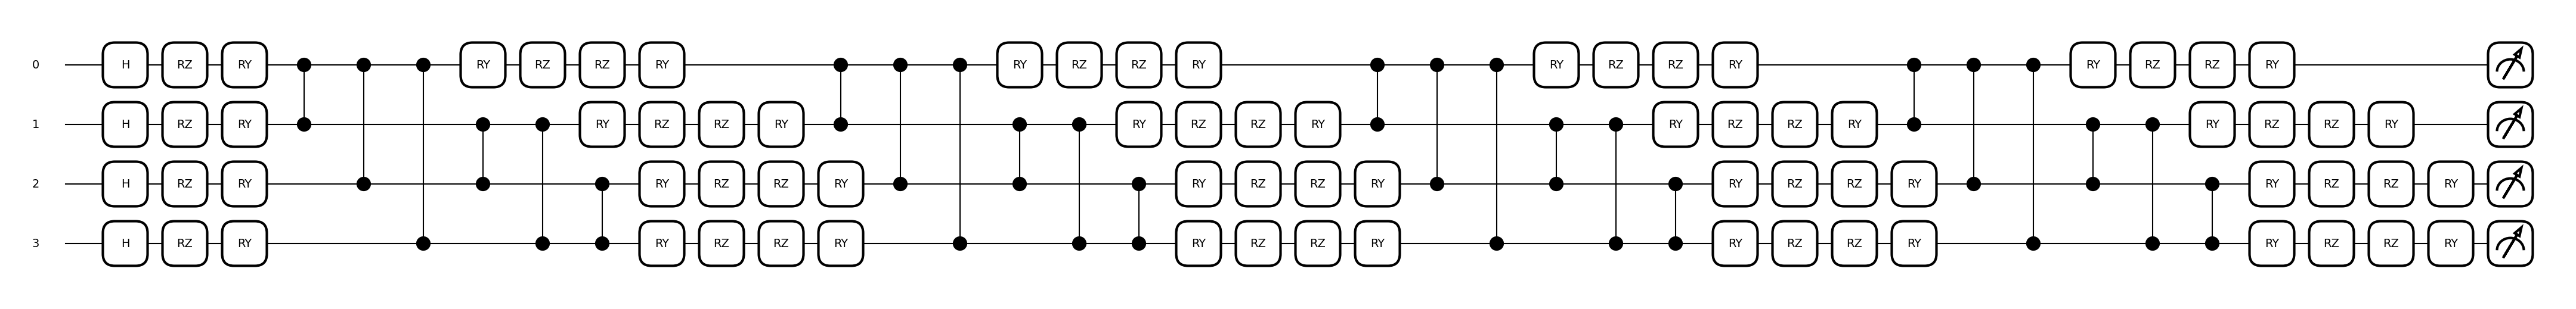

In [24]:
n_qubits = 4
n_layers = 4
shots = None
diff_method = 'backprop' 
entanglement = True
entanglement_pattern = "all_to_all"
entanglement_gate = qml.CZ
input_scaling = True
input_init = torch.nn.init.ones_
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     input_scaling, input_init, weight_init, policy_circuit_measure)

policy_circuit.visualize_circuit()
#policy_circuit.circuit_spectrum()

In [ ]:
n_qubits = 4
n_layers = 4
shots = None
diff_method = 'best' 
entanglement = True
entanglement_pattern = "all_to_all"
entanglement_gate = qml.CZ
input_scaling = True
input_init = torch.nn.init.ones_
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).normal_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     input_scaling, input_init, weight_init, policy_circuit_measure)

#value_circuit_measure = one_measure_expval_global
#value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
#                     entanglement, entanglement_pattern, entanglement_gate, 
#                     input_scaling, input_init, weight_init, value_circuit_measure)

n_actions = 2
post_processing = 'softmax'
beta_scheduling = True
beta = 1
increase_rate = 0.0005
output_scaling = True
output_init = torch.nn.init.ones_
policy_post_process = PolicyPostProcessing(n_actions, 
                         post_processing, 
                         beta_scheduling, 
                         beta, increase_rate, 
                         output_scaling, 
                         output_init)

policy = QuantumPolicy(policy_circuit,policy_post_process)

policy_lr_list= [0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

value_lr_list = [0.01, 0.1]
#value_params = list(value_circuit.parameters())
#value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

env_name = 'CartPole-v1'
n_episodes = 5000
max_t = 500
gamma = 0.98
print_every = 10
verbose = 1
reinforce_update = ReinforceAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceBatchAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceSimpleBaselineAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceDynamicBaselineAgent(policy, policy_optimizer, value_circuit, value_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
reinforce_update.train()

## UQC

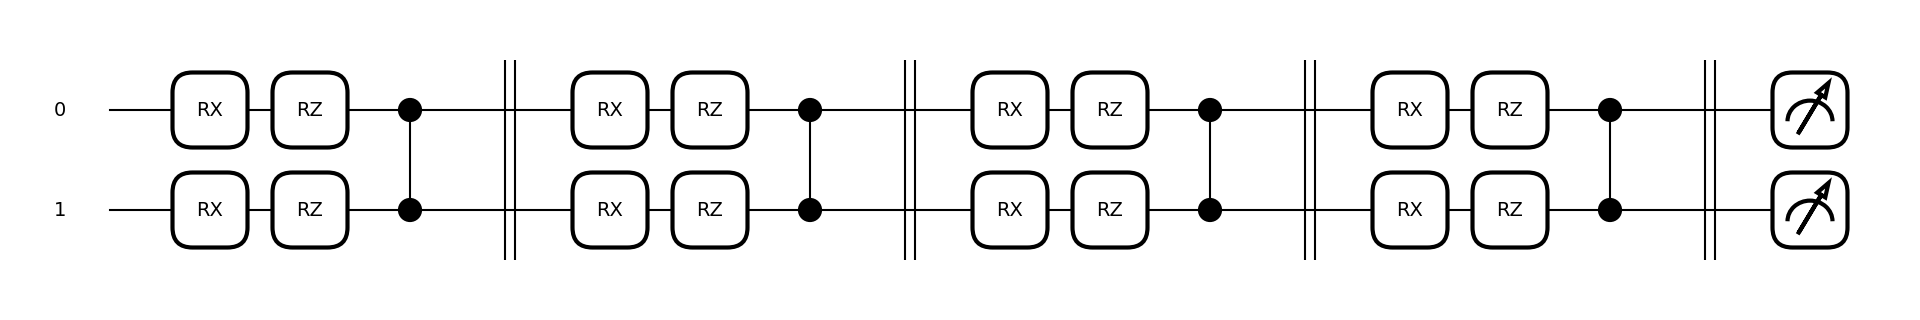

In [90]:
n_qubits = 2
n_layers = 4
state_dim = 4
shots = None
diff_method = 'best' 
entanglement = True
entanglement_pattern = "all_to_all"
entanglement_gate = qml.CZ
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = UQC(n_qubits, n_layers, state_dim, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     weight_init, policy_circuit_measure)

policy_circuit.visualize_circuit()

In [ ]:
n_qubits = 1
n_layers = 4
state_dim = 4
shots = None
diff_method = 'best' 
entanglement = True
entanglement_pattern = "all_to_all"
entanglement_gate = qml.CZ
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = UQC(n_qubits, n_layers, state_dim, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     weight_init, policy_circuit_measure)

#value_circuit_measure = one_measure_expval_global
#value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
#                     entanglement, entanglement_pattern, entanglement_gate, 
#                     input_scaling, input_init, weight_init, value_circuit_measure)

n_actions = 2
post_processing = 'softmax'
beta_scheduling = False
beta = 1
increase_rate = 0.003
output_scaling = False
output_init = torch.nn.init.ones_
policy_post_process = PolicyPostProcessing(n_actions, 
                         post_processing, 
                         beta_scheduling, 
                         beta, increase_rate, 
                         output_scaling, 
                         output_init)

policy = QuantumPolicy(policy_circuit,policy_post_process)

policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

value_lr_list = [0.01, 0.1]
#value_params = list(value_circuit.parameters())
#value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

env_name = 'CartPole-v1'
n_episodes = 5000
max_t = 500
gamma = 0.98
print_every = 10
verbose = 1
reinforce_update = ReinforceAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceBatchAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceSimpleBaselineAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceDynamicBaselineAgent(policy, policy_optimizer, value_circuit, value_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
reinforce_update.train()

## TFQ Tutorial

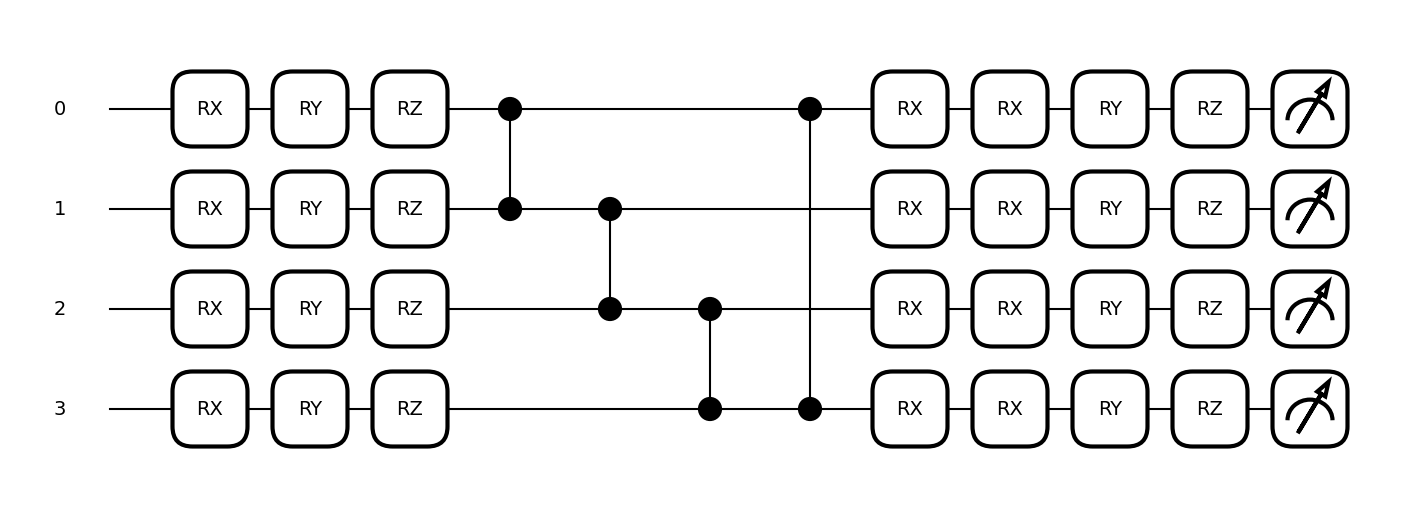

In [24]:
n_qubits = 4
n_layers = 1
shots = None
diff_method = 'best' 
entanglement = True
entanglement_pattern = "ring"
entanglement_gate = qml.CZ
input_scaling = True
input_init = torch.nn.init.ones_
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = TfqTutorial(n_qubits, n_layers, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     input_scaling, input_init, weight_init, policy_circuit_measure)

policy_circuit.visualize_circuit()

In [27]:
n_qubits = 4
n_layers = 1
shots = None
diff_method = 'best' 
entanglement = True
entanglement_pattern = "ring"
entanglement_gate = qml.CZ
input_scaling = True
input_init = torch.nn.init.ones_
weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
policy_circuit_measure = two_measure_expval_global
policy_circuit = TfqTutorial(n_qubits, n_layers, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     input_scaling, input_init, weight_init, policy_circuit_measure)

value_circuit_measure = one_measure_expval_global
value_circuit = TfqTutorial(n_qubits, n_layers, shots, diff_method, 
                     entanglement, entanglement_pattern, entanglement_gate, 
                     input_scaling, input_init, weight_init, value_circuit_measure)

n_actions = 2
post_processing = 'softmax'
beta_scheduling = True
beta = 1
increase_rate = 0.0005
output_scaling = False
output_init = torch.nn.init.ones_
policy_post_process = PolicyPostProcessing(n_actions, 
                         post_processing, 
                         beta_scheduling, 
                         beta, increase_rate, 
                         output_scaling, 
                         output_init)

policy = QuantumPolicy(policy_circuit,policy_post_process)

policy_lr_list= [0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

value_lr_list = [0.01, 0.1]
value_params = list(value_circuit.parameters())
value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

env_name = 'CartPole-v1'
n_episodes = 5000
max_t = 500
gamma = 0.98
print_every = 10
verbose = 1
reinforce_update = ReinforceAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceBatchAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceSimpleBaselineAgent(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
#reinforce_update = ReinforceDynamicBaselineAgent(policy, policy_optimizer, value_circuit, value_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose)
reinforce_update.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1	Last reward: 25.00	Runtime: 0.60s	 
Episode 2	Last reward: 9.00	Runtime: 0.19s	 
Episode 3	Last reward: 25.00	Runtime: 0.49s	 
Episode 4	Last reward: 16.00	Runtime: 0.34s	 
Episode 5	Last reward: 12.00	Runtime: 0.25s	 
Episode 6	Last reward: 22.00	Runtime: 0.48s	 
Episode 7	Last reward: 20.00	Runtime: 0.44s	 
Episode 8	Last reward: 47.00	Runtime: 0.92s	 
Episode 9	Last reward: 19.00	Runtime: 0.40s	 
Episode 10	Last reward: 19.00	Runtime: 0.39s	 Last 10 Episodes average reward: 21.40	 
Episode 11	Last reward: 10.00	Runtime: 0.21s	 
Episode 12	Last reward: 14.00	Runtime: 0.28s	 
Episode 13	Last reward: 27.00	Runtime: 0.53s	 
Episode 14	Last reward: 66.00	Runtime: 1.31s	 
Episode 15	Last reward: 43.00	Runtime: 0.91s	 
Episode 16	Last reward: 15.00	Runtime: 0.33s	 
Episode 17	Last reward: 17.00	Runtime: 0.34s	 
Episode 18	Last reward: 39.00	Runtime: 0.75s	 
Episode 19	Last reward: 24.00	Runtime: 0.49s	 
Episode 20	Last reward: 17.00	Runtime: 0.35s	 Last 10 Episodes average reward

KeyboardInterrupt: 

## Other tests

# Multiple agents

In [ ]:
data_directory = "../../data"

def train_agents(pqc, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceAgent(pqc, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose)
    reinforce_update.train(file_name, rundate, data_directory, True)

    return reinforce_update.scores

if __name__ == "__main__":
    n_qubits = 1
    n_layers = 1
    state_dim = 4
    shots = None
    diff_method = 'best' 
    entanglement = True
    entanglement_pattern = "all_to_all"
    entanglement_gate = qml.CZ
    weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    policy_circuit_measure = two_measure_expval_global
    policy_circuit = UQC(n_qubits, n_layers, state_dim, shots, diff_method, 
                        entanglement, entanglement_pattern, entanglement_gate, 
                        weight_init, policy_circuit_measure)

    #value_circuit_measure = one_measure_expval_global
    #value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
    #                     entanglement, entanglement_pattern, entanglement_gate, 
    #                     input_scaling, input_init, weight_init, value_circuit_measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling = False
    beta = 1
    increase_rate = 0.003
    output_scaling = False
    output_init = torch.nn.init.ones_
    policy_post_process = PolicyPostProcessing(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicy(policy_circuit,policy_post_process)

    policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
    policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
    policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

    value_lr_list = [0.01, 0.1]
    #value_params = list(value_circuit.parameters())
    #value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

    env_name = 'CartPole-v1'
    n_episodes = 5000
    max_t = 500
    gamma = 0.98
    print_every = 10
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, i, rundate) for i in range(num_agents))
    print(results)

In [ ]:
data_directory = "../../data"

def train_agents(pqc, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceAgent(pqc, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose)
    reinforce_update.train(file_name, rundate, data_directory, True)

    return reinforce_update.scores

if __name__ == "__main__":
    n_qubits = 1
    n_layers = 2
    state_dim = 4
    shots = None
    diff_method = 'best' 
    entanglement = True
    entanglement_pattern = "all_to_all"
    entanglement_gate = qml.CZ
    weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    policy_circuit_measure = two_measure_expval_global
    policy_circuit = UQC(n_qubits, n_layers, state_dim, shots, diff_method, 
                        entanglement, entanglement_pattern, entanglement_gate, 
                        weight_init, policy_circuit_measure)

    #value_circuit_measure = one_measure_expval_global
    #value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
    #                     entanglement, entanglement_pattern, entanglement_gate, 
    #                     input_scaling, input_init, weight_init, value_circuit_measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling = False
    beta = 1
    increase_rate = 0.003
    output_scaling = False
    output_init = torch.nn.init.ones_
    policy_post_process = PolicyPostProcessing(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicy(policy_circuit,policy_post_process)

    policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
    policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
    policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

    value_lr_list = [0.01, 0.1]
    #value_params = list(value_circuit.parameters())
    #value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

    env_name = 'CartPole-v1'
    n_episodes = 5000
    max_t = 500
    gamma = 0.98
    print_every = 10
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, i, rundate) for i in range(num_agents))
    print(results)

In [ ]:
data_directory = "../../data"

def train_agents(pqc, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceAgent(pqc, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose)
    reinforce_update.train(file_name, rundate, data_directory, True)

    return reinforce_update.scores

if __name__ == "__main__":
    n_qubits = 1
    n_layers = 1
    state_dim = 4
    shots = None
    diff_method = 'best' 
    entanglement = True
    entanglement_pattern = "all_to_all"
    entanglement_gate = qml.CZ
    input_scaling = True
    input_init = torch.nn.init.ones_
    weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    policy_circuit_measure = two_measure_expval_global
    policy_circuit = TfqTutorial(n_qubits, n_layers, state_dim, shots, diff_method, 
                                 entanglement, entanglement_pattern, entanglement_gate, input_scaling,
                                 input_init, weight_init, policy_circuit_measure)

    #value_circuit_measure = one_measure_expval_global
    #value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
    #                     entanglement, entanglement_pattern, entanglement_gate, 
    #                     input_scaling, input_init, weight_init, value_circuit_measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling = False
    beta = 1
    increase_rate = 0.003
    output_scaling = False
    output_init = torch.nn.init.ones_
    policy_post_process = PolicyPostProcessing(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicy(policy_circuit,policy_post_process)

    policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
    policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
    policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

    value_lr_list = [0.01, 0.1]
    #value_params = list(value_circuit.parameters())
    #value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

    env_name = 'CartPole-v1'
    n_episodes = 5000
    max_t = 500
    gamma = 0.98
    print_every = 10
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, i, rundate) for i in range(num_agents))
    print(results)

In [ ]:
data_directory = "../../data"

def train_agents(pqc, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceAgent(pqc, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose)
    reinforce_update.train(file_name, rundate, data_directory, True)

    return reinforce_update.scores

if __name__ == "__main__":
    n_qubits = 1
    n_layers = 2
    state_dim = 4
    shots = None
    diff_method = 'best' 
    entanglement = True
    entanglement_pattern = "all_to_all"
    entanglement_gate = qml.CZ
    weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    policy_circuit_measure = two_measure_expval_global
    policy_circuit = TfqTutorial(n_qubits, n_layers, state_dim, shots, diff_method, 
                                 entanglement, entanglement_pattern, entanglement_gate, input_scaling,
                                 input_init, weight_init, policy_circuit_measure)

    #value_circuit_measure = one_measure_expval_global
    #value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
    #                     entanglement, entanglement_pattern, entanglement_gate, 
    #                     input_scaling, input_init, weight_init, value_circuit_measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling = False
    beta = 1
    increase_rate = 0.003
    output_scaling = False
    output_init = torch.nn.init.ones_
    policy_post_process = PolicyPostProcessing(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicy(policy_circuit,policy_post_process)

    policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
    policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
    policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

    value_lr_list = [0.01, 0.1]
    #value_params = list(value_circuit.parameters())
    #value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

    env_name = 'CartPole-v1'
    n_episodes = 5000
    max_t = 500
    gamma = 0.98
    print_every = 10
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, i, rundate) for i in range(num_agents))
    print(results)

In [ ]:
data_directory = "../../data"

def train_agents(pqc, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceAgent(pqc, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose)
    reinforce_update.train(file_name, rundate, data_directory, True)

    return reinforce_update.scores

if __name__ == "__main__":
    n_qubits = 1
    n_layers = 4
    state_dim = 4
    shots = None
    diff_method = 'best' 
    entanglement = True
    entanglement_pattern = "all_to_all"
    entanglement_gate = qml.CZ
    weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    policy_circuit_measure = two_measure_expval_global
    policy_circuit = AlternateEntanglement(n_qubits, n_layers, state_dim, shots, diff_method, 
                        entanglement,, 
                        weight_init, policy_circuit_measure)

    #value_circuit_measure = one_measure_expval_global
    #value_circuit = JerbiModel(n_qubits, n_layers, shots, diff_method, 
    #                     entanglement, entanglement_pattern, entanglement_gate, 
    #                     input_scaling, input_init, weight_init, value_circuit_measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling = False
    beta = 1
    increase_rate = 0.003
    output_scaling = False
    output_init = torch.nn.init.ones_
    policy_post_process = PolicyPostProcessing(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicy(policy_circuit,policy_post_process)

    policy_lr_list= [0.1, 0.01, 0.1, 0.1]  # [weights, input_weights, output_weights]
    policy_params = list(policy_circuit.parameters()) + list(policy_post_process.parameters())
    policy_optimizer= create_optimizer_with_lr(policy_params, policy_lr_list, use_amsgrad=True)

    value_lr_list = [0.01, 0.1]
    #value_params = list(value_circuit.parameters())
    #value_optimizer = create_optimizer_with_lr(value_params, value_lr_list)

    env_name = 'CartPole-v1'
    n_episodes = 5000
    max_t = 500
    gamma = 0.98
    print_every = 10
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 10

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, policy_optimizer, env_name, n_episodes, max_t, gamma, print_every, verbose, i, rundate) for i in range(num_agents))
    print(results)

# Optuna

In [ ]:
# Parallel runs
import optuna
from IPython.display import clear_output, display

current_directory = os.getcwd()

def train_agents(policy, optimizers,env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate):

    reinforce_update = ReinforceUpdate(policy, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose, file_name, rundate)
    reinforce_update.train()

    return reinforce_update.scores

def objective_function(results):

    results_mean = np.mean(results, axis=0)
    area = np.abs(np.trapz(results_mean))
    maximum_performance_area = float(len(results[0]) * 200)

    # Create a metric called performance area and normalize it between 0 and 1
    performance_area = area / maximum_performance_area
    return performance_area

'''
def sum_and_average(results):

    averages = np.mean(results, axis=1)
    return np.mean(averages)
'''

def objective(trial):    

    n_qubits = 4
    n_layers = 4      #set to 1 if data_reuploading is off
    entanglement = "all_to_all"
    shots = None
    input_scaling = True
    design = 'jerbi_circuit' 
    diff_method = 'backprop' 
    weight_init = torch.nn.init.normal_
    #weight_init = lambda shape, dtype=torch.float: torch.FloatTensor(shape).uniform_(-np.pi, np.pi)
    input_init = torch.nn.init.ones_
    measure = measure_expval_pairs
    circuit = CircuitGenerator(n_qubits, 
                            n_layers,
                            entanglement,
                            shots,
                            input_scaling,
                            design,
                            diff_method,
                            weight_init,
                            input_init,
                            measure)

    n_actions = 2
    post_processing = 'softmax'
    beta_scheduling, beta, increase_rate = True, 1, 0.005
    output_scaling, output_init = False, torch.nn.init.ones_
    policy_type = PolicyType(n_actions, 
                            post_processing, 
                            beta_scheduling, 
                            beta, 
                            increase_rate, 
                            output_scaling, 
                            output_init)

    policy = QuantumPolicyModel(circuit,policy_type)

    lr1 = trial.suggest_float("lr1", 1e-5, 1e-1, log=True)
    #lr2 = trial.suggest_float("lr2", 1e-5, 1e-1, log=True)
    #lr3 = trial.suggest_float("lr3", 1e-5, 1e-1, log=True)
    lr2, lr3 = 0.1, 0.1
    lr_list= [lr1, lr2, lr3]  # [weights, input_weights, output_weights]
    circuit_params = list(circuit.parameters())
    policy_params = list(policy_type.parameters())
    params = circuit_params + policy_params
    optimizers= create_optimizer_with_lr(params,lr_list)
    env_name = 'CartPole-v1'
    n_episodes = 10
    max_t = 500
    gamma = 0.98
    print_every = 1
    verbose = 1
    rundate = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')      
    num_agents = 5

    results = Parallel(n_jobs=num_agents)(delayed(train_agents)(policy, optimizers, env_name, n_episodes, max_t, gamma, print_every, verbose, i, trial.number) for i in range(num_agents))
    performance_metric = objective_function(results)
    #performance_metric = sum_and_average(results)
    return performance_metric

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print(f"Best trial: {study.best_trial.value}")
    print(f"Best parameters: {study.best_trial.params}")

In [ ]:
softmax_output = F.softmax(torch.Tensor([0.1,0.9]) * 3, dim=0)
print(softmax_output)